In [1]:
import glob
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from astropy.io import fits

from spectra import *
from fitting import *

## Plotting data to see what it looks like...

In [2]:
fnames = glob.glob("data/science/*.nspec")

objects = {}
for fn in fnames:
    proplyd = ProplydData(fn)
    proplyd.x *= 1e4
    objects[proplyd.name] = proplyd

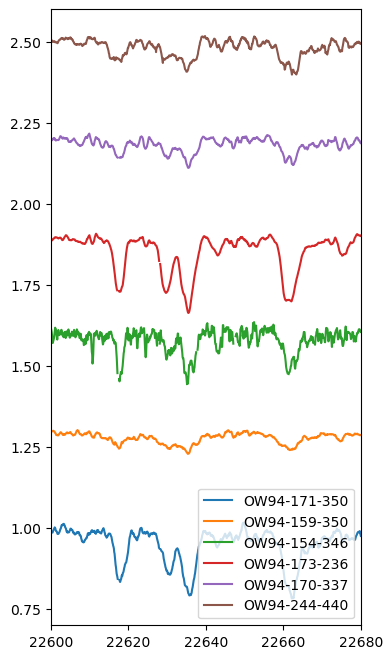

In [3]:
plt.figure(figsize=(4,8))
for i, (name,obj) in enumerate(objects.items()):
    plt.plot(obj.x, obj.y + i*0.3, label=obj.name)
plt.legend()
plt.ylim(0.7,2.6)
plt.xlim(22600,22680)
plt.show()

## Finding doppler shifts by hand

I set up a dictionary that will be converted to a CSV file later. I also find the Doppler shifts by hand in region 5 here. For now, I use the same shift for all regions. Later, you can see that the shifts are slightly off between wavelength regions.


The process for finding doppler shifts should probably be automated by doing some sort of cross-correlation.

In [4]:
best_models_dict = {"Name": ["Teff", "logg", "rK", "vsini", "B", "shift"]} # store all params here
shifts = np.zeros(len(objects))  # doppler shifts

In [5]:
# I determined these values using the code cell below
shifts = [-44, -40, -43, -43, -42, -40]

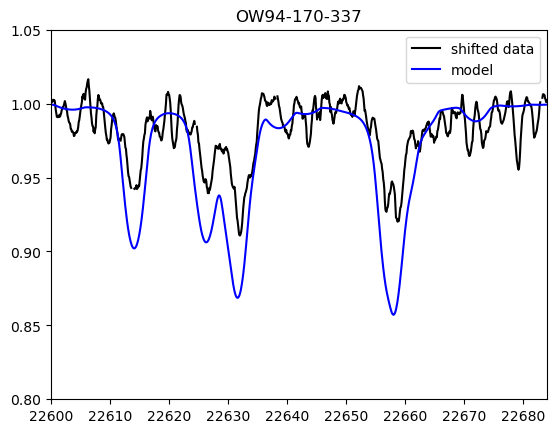

In [6]:
i = 4
name, obj_test = copy.deepcopy( list(objects.items())[i] )
shift = -40
# shifts[i] = shift

xlo, xhi = 22600, 22684

# Visually determine the doppler shift, shift the data back
model = MoogStokesModel(4000, 4, rK=1, B=0, vsini=32, region=5)

obj_test.doppler_shift_data(shift)

plt.figure()
plt.plot(obj_test.x, obj_test.y, c='k', label="shifted data")
plt.plot(model.x, model.y, c='blue', label="model")
plt.legend()
plt.xlim(xlo, xhi)
plt.ylim(0.8, 1.05)
plt.title(name)
plt.show()

## Fit the object across a grid with minimum chi-squared

In [13]:
# Define grid
Teff_vals = np.arange(3000, 5001, 200)
logg_vals = np.arange(2.75, 4.51, 0.25)
rK_vals = np.arange(0, 5.1, 0.2)
vsini_vals = np.arange(2, 43, 5)
B_vals = np.arange(0, 4, 1)

In [7]:
# Run each model across the grid - THIS CAN TAKE A LONG TIME
for i in range(6):
    name, obj = list(objects.items())[i]
    shift = shifts[i]

    # doppler shift the data for real this time
    obj.doppler_shift_data(shift)

    if name == "OW94-170-337":
        # Skip region 3 for this object
        regions = [0, 1, 2, 4, 5, 6]
    else:
        regions = range(7)
    chi2_grid = compute_moogstokes_chi2_grid(obj, Teff_vals, logg_vals, rK_vals, vsini_vals, B_vals, regions=regions)

    # Store best-fit parameters and shift for each object
    Teff, logg, rK, vsini, B = best_chi2_grid_params(chi2_grid, Teff_vals, logg_vals, rK_vals, vsini_vals, B_vals)
    best_models_dict[obj.name] = [Teff, logg, rK, vsini, B, shift]

KeyboardInterrupt: 

## Store the best fit parameters in a table

Convert to a pandas dataframe and export as CSV

In [ ]:
best_models = pd.DataFrame(data=best_models_dict)
best_models = best_models.T.reset_index()

new_header = best_models.iloc[0] #grab the first row for the header
best_models = best_models[1:] #take the data less the header row
best_models.columns = new_header #set the header row as the df header

best_models.to_csv("data/best_models.csv", index=False)

If you restarted the kernel and don't want to perform the fit again, you can read in the CSV like this:

In [7]:
best_models = pd.read_csv("data/best_models.csv", index_col=False)
best_models = best_models.set_index("Name")  # remove index column
best_models

,Teff,logg,rK,vsini,B,shift
Name,,,,,,
OW94-171-350,3600.0,3.50,0.8,22.0,2.0,-44.0
OW94-159-350,4000.0,4.00,3.8,42.0,3.0,-40.0
OW94-154-346,3400.0,3.50,2.6,7.0,1.0,-43.0
OW94-173-236,4000.0,3.50,0.4,27.0,2.0,-43.0
OW94-170-337,3600.0,3.75,5.0,22.0,2.0,-42.0
OW94-244-440,3000.0,2.75,3.6,32.0,3.0,-40.0


Below is a helper function that creates a MoogStokesModel object based on the parameters from the dataframe.

In [8]:
def get_moogstokes_from_df(best_models_df, name, region):
    """Returns a model based on parameters from the dataframe.

    Parameters
    ----------
    best_models_df: pandas.DataFrame
        Dataframe containing best model parameters. See the cell above.
    name: str
        Object name.
    region: int
        Wavelength region defined in spectra.MoogStokesModel.region_xlims().

    Returns
    -------
    model: MoogStokesModel
        Best fit model for the object.
    """
    result = best_models_df.loc[name]
    Teff = result["Teff"]
    logg = result["logg"]
    rK = result["rK"]
    vsini = result["vsini"]
    B = result["B"]
    shift = result["shift"]
    model = MoogStokesModel(Teff, logg, rK, B, vsini, region)
    return model

## Plot the best fit model

In [9]:
fnames = glob.glob("data/science/*.nspec")

objects = {}
for fn in fnames:
    proplyd = ProplydData(fn)
    proplyd.x *= 1e4
    objects[proplyd.name] = proplyd

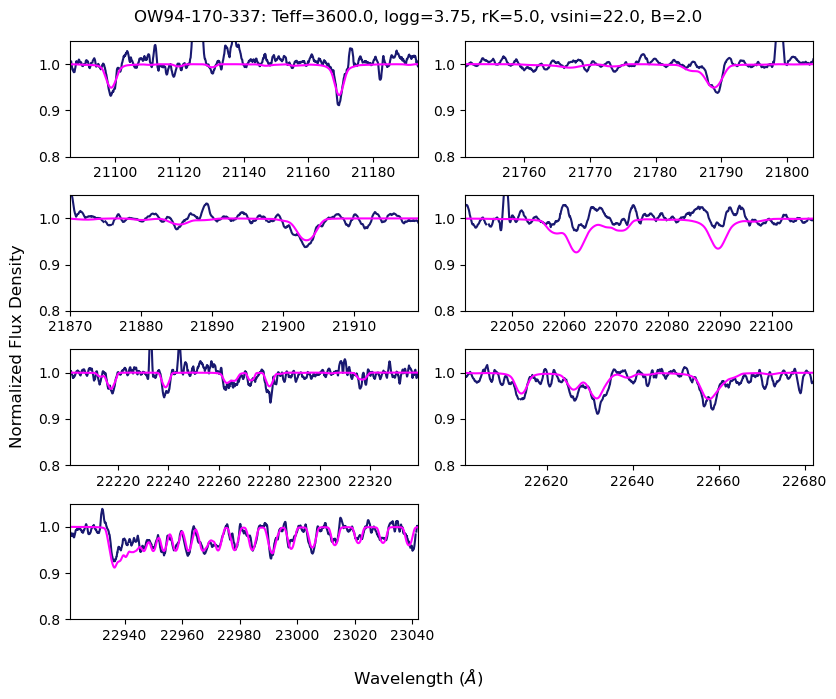

In [10]:
name = "OW94-170-337"  # pick an object to plot
obj = objects[name]   # reason for importing objects again before plotting is remove extra doppler shifts

# Apply doppler shift
shift = best_models.loc[name, "shift"]
obj.doppler_shift_data(shift)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8.5,7))

for r, ax in enumerate(axs.reshape(-1)):
    if r == 7:
        ax.axis("off")
        continue
        
    # This is the best model we found
    model = get_moogstokes_from_df(best_models, name, region=r)
    
    ax.plot(obj.x, obj.y, c='midnightblue')
    ax.plot(model.x, model.y, c='magenta')
    ax.set_ylim(0.8,1.05)
    
    xlo, xhi = model.region_xlims(r)
    ax.set_xlim(xlo,xhi)
    
fig.suptitle(f"{name}: Teff={model.Teff}, logg={model.logg}, rK={round(model.rK,2)}, vsini={model.vsini}, B={model.B}")
fig.supxlabel(r"Wavelength ($\AA$)")
fig.supylabel(r"Normalized Flux Density")
plt.tight_layout()
#fig.savefig(f"figures/model_plots/{name}_Teff{model.Teff}_logg{model.logg}_rK{round(model.rK,2)}_vsini{model.vsini}_B{model.B}.png", dpi=98, facecolor="white")
plt.show()

## Plot with Feiden (2016) magnetic isochrones

In [11]:
# Import isochrones
model_ages = [1, 2, 4, 8, 15, 30, 50]          # in Myr
iso_models = []

for num in model_ages:
    fname = 'data/isochrones/dmestar_' + str(num) +'myr.txt'
    arr = np.loadtxt(fname, skiprows=5).T
    m = arr[0]
    teff = 10**arr[1]      # convert from logTeff to Teff
    logg = arr[2]
    iso_models.append([m, teff, logg])

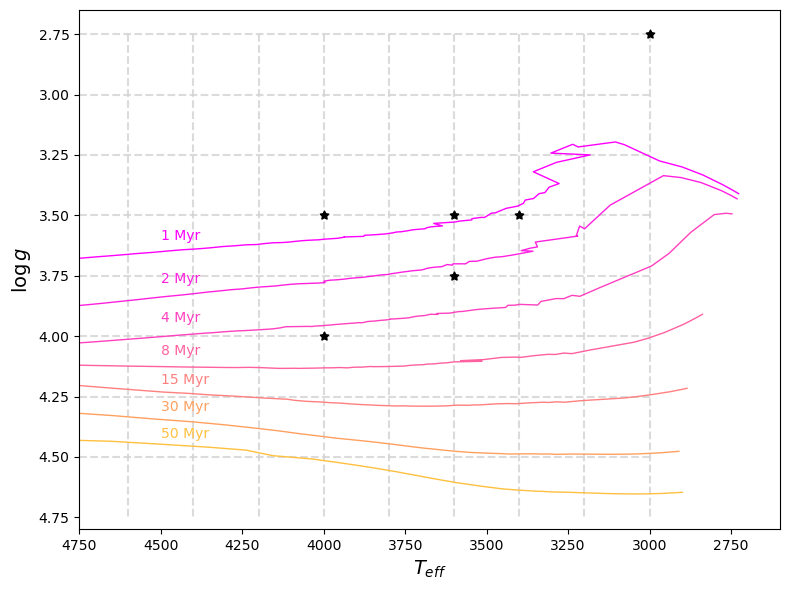

In [14]:
plt.figure(figsize=(8,6))

# Isochrones and labels
n = 9
tshifts = [0, 0.02, 0.02, 0, -0.04, -0.09, -0.14]
colors = plt.cm.spring(np.linspace(0,1,n))
for i in range(len(model_ages)):
    plt.plot(iso_models[i][1], iso_models[i][2], zorder=1, label=str(model_ages[i]) + ' Myr', linewidth=1, c=colors[i])
    plt.text(4500, 3.6+0.16*i+tshifts[i], f"{model_ages[i]} Myr", c=colors[i], zorder=1)

# Show objects as points
Teffs = []
loggs = []
names = []
for row in best_models.iterrows():
    names.append(row[0])
    Teffs.append(row[1]["Teff"])
    loggs.append(row[1]["logg"])
plt.scatter(Teffs, loggs, c='k', marker=(5, 1), s=40, zorder=2)

# Show grid of models
plt.vlines(Teff_vals, 2.75, 4.75, zorder=0, linestyles='--', colors='lightgray', alpha=0.8)
plt.hlines(logg_vals, 3000, 4800, zorder=0, linestyles='--', colors='lightgray', alpha=0.8)


plt.xlim(2600, 4750)
plt.ylim(2.65, 4.8)
plt.xlabel(r'$T_{eff}$', fontsize=14)
plt.ylabel(r'$\log g$', fontsize=14)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('figures/ages.png', facecolor='white', dpi=98)
plt.show()